In [41]:
import pandas as pd
import os
import re
import plotly.express as px
import plotly.graph_objects as go
import plotlyshare
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# 1. number of structures analysis

In [2]:
cgc_data = pd.read_csv('Census_all_with_pdb.csv')

In [3]:
fig = px.histogram(cgc_data, x="n_structures")
fig.show()

In [4]:
# horizontal boxplot
fig = px.box(cgc_data, x="n_structures", orientation='h')
fig.show()

### read clean residue data

In [34]:
residue_data = pd.read_csv('final_data.csv')
residue_data.head()

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
0,EGFR,3POZ,A,P00533,EGFR,1.5,701,Q,Q,-3.791355,False,True
1,EGFR,3POZ,A,P00533,EGFR,1.5,702,A,A,-2.634055,False,True
2,EGFR,3POZ,A,P00533,EGFR,1.5,703,L,L,-1.231055,False,True
3,EGFR,3POZ,A,P00533,EGFR,1.5,704,L,L,0.452193,False,True
4,EGFR,3POZ,A,P00533,EGFR,1.5,705,R,R,-1.086163,False,True


In [35]:
residue_data[residue_data['gene_symbol']=="EGFR"]['pdb_id'].unique()

array(['3POZ', '3VRP', '3W32', '3W33', '4I22', '4I24', '5CNO', '5GNK',
       '5HG5', '5HG8', '5U8L', '5UG8', '5UG9', '5UGA', '5UGC', '6TFV',
       '6TFY', '6TFZ', '6TG0', '6TG1', '6V66', '6WXN', '7JXQ', '7SI1',
       '8A27', '8A2A', '8A2B', '8A2D'], dtype=object)

In [36]:
# count number of unique pdb_id for each gene
residue_data.groupby('gene_symbol')['pdb_id'].nunique().reset_index()

,gene_symbol,pdb_id
0,EGFR,28
1,HRAS,30
2,KRAS,31
3,TP53,109


# 2. Compare NS between different crystals of same protein

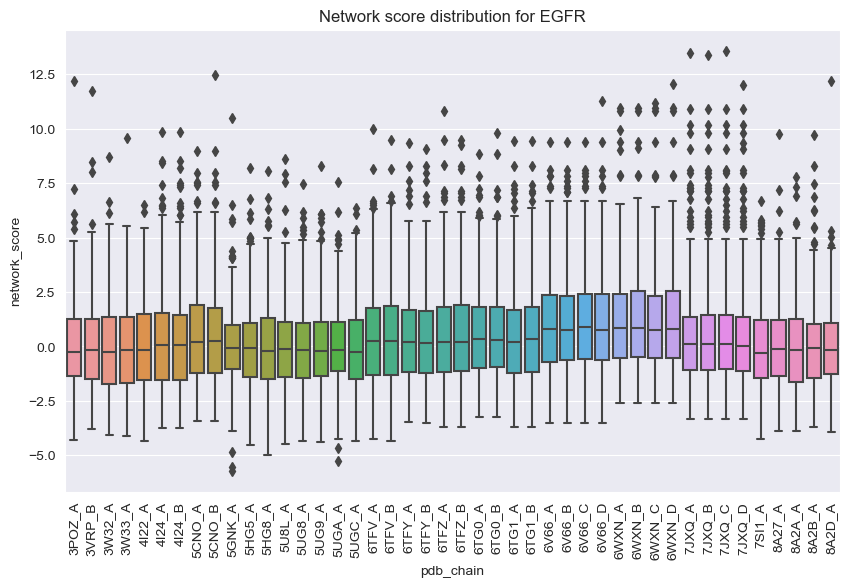

In [37]:
tmp = residue_data[residue_data['gene_symbol']=="EGFR"].reset_index(drop=True)
tmp['pdb_chain'] = tmp['pdb_id'] + '_' + tmp['chain']

# plot boxplot of network score for EGFR for each pdb_chain
plt.figure(figsize=(10, 6))
sns.boxplot(data=tmp, x='pdb_chain', y='network_score')
plt.xticks(rotation=90)
plt.title('Network score distribution for EGFR')
plt.show()

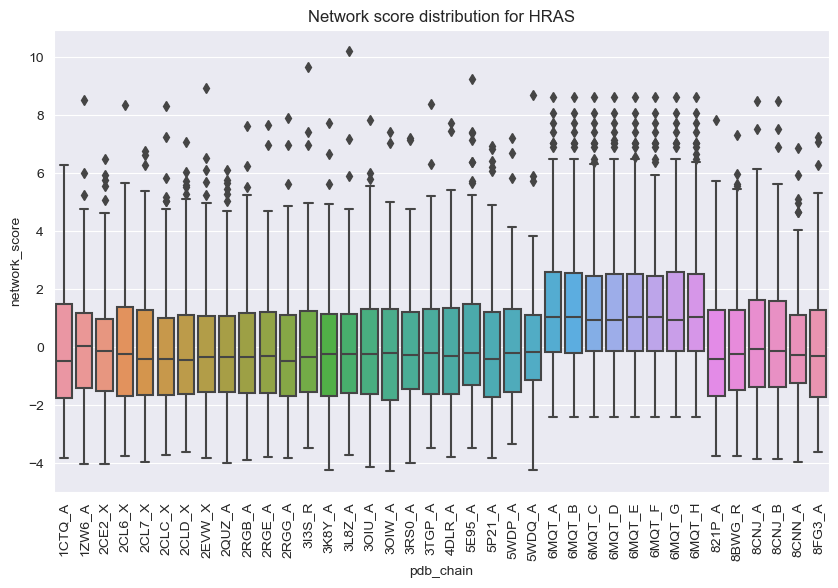

In [38]:
tmp = residue_data[residue_data['gene_symbol']=="HRAS"].reset_index(drop=True)
tmp['pdb_chain'] = tmp['pdb_id'] + '_' + tmp['chain']

# plot boxplot of network score for EGFR for each pdb_chain
plt.figure(figsize=(10, 6))
sns.boxplot(data=tmp, x='pdb_chain', y='network_score')
plt.xticks(rotation=90)
plt.title('Network score distribution for HRAS')
plt.show()

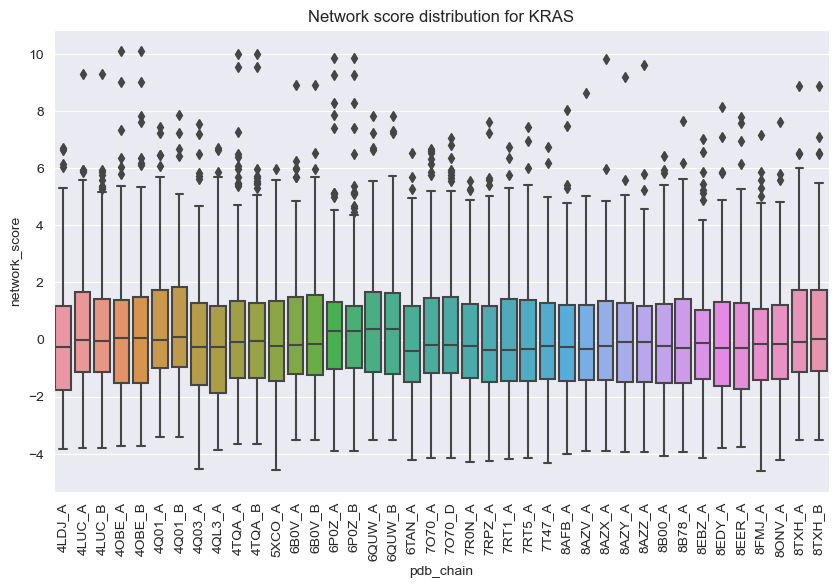

In [39]:
tmp = residue_data[residue_data['gene_symbol']=="KRAS"].reset_index(drop=True)
tmp['pdb_chain'] = tmp['pdb_id'] + '_' + tmp['chain']

# plot boxplot of network score for EGFR for each pdb_chain
plt.figure(figsize=(10, 6))
sns.boxplot(data=tmp, x='pdb_chain', y='network_score')
plt.xticks(rotation=90)
plt.title('Network score distribution for KRAS')
plt.show()

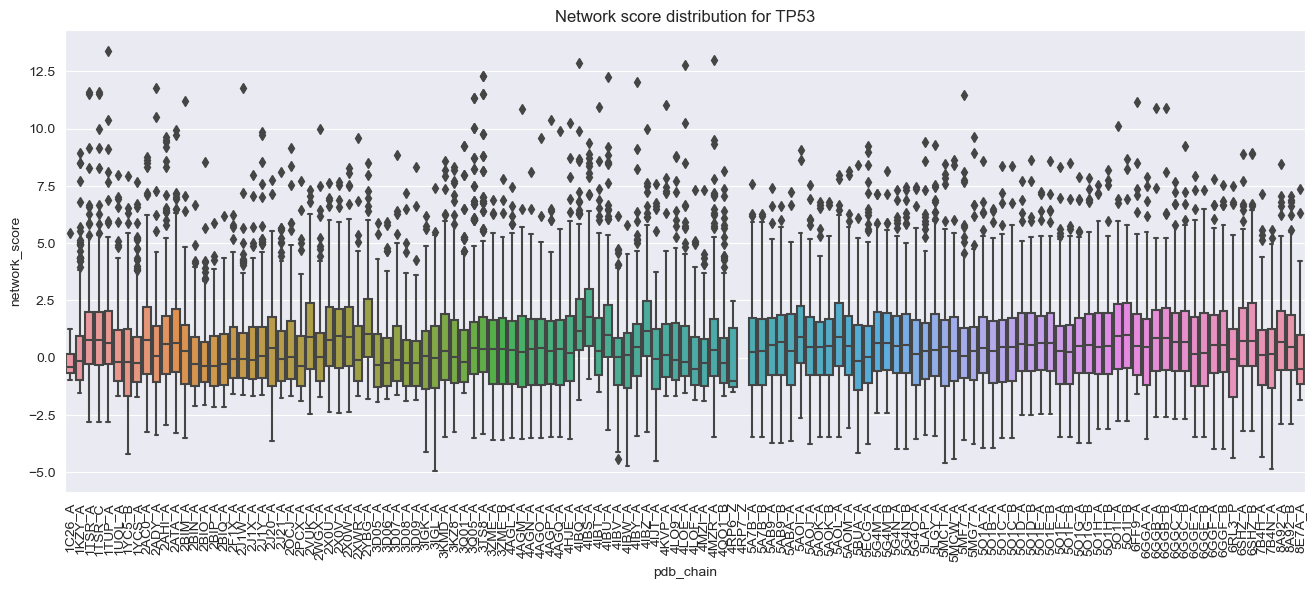

In [40]:
tmp = residue_data[residue_data['gene_symbol']=="TP53"].reset_index(drop=True)
tmp['pdb_chain'] = tmp['pdb_id'] + '_' + tmp['chain']

# plot boxplot of network score for EGFR for each pdb_chain
plt.figure(figsize=(16, 6))
sns.boxplot(data=tmp, x='pdb_chain', y='network_score')
plt.title('Network score distribution for TP53')
plt.xticks(rotation=90)
plt.show()

# 2. TCGA data

In [8]:
residue_data = pd.read_csv('final_data.csv')
residue_data = residue_data.sort_values("assoc_gene", ascending=True)
residue_data 
residue_data.head()

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
0,EGFR,3POZ,A,P00533,EGFR,1.50,701,Q,Q,-3.791355,False,True
8569,EGFR,6V66,C,P00533,EGFR,1.79,909,T,T,0.551312,False,True
8570,EGFR,6V66,C,P00533,EGFR,1.79,910,F,F,1.368711,False,True
8571,EGFR,6V66,C,P00533,EGFR,1.79,911,G,G,3.902907,False,True
8572,EGFR,6V66,C,P00533,EGFR,1.79,912,S,S,1.386478,False,True


In [9]:
all_merged_data = pd.DataFrame()

# map assoc_gene + residues to their mutational frequency 
for file in os.listdir('TCGA_data'):
    
    # extract gene name from file name
    gene = re.match(r'^([A-Z0-9]+)', file).group(1)
    
    # filter residue data for gene
    filtered_data = residue_data[residue_data['gene_symbol']==gene]
    
    # read tp53 TCGA data
    missense_data = pd.read_csv(f"TCGA_data/{file}", sep='\t')

    # filter for missense mutations
    missense_data = missense_data[missense_data['consequence']=="Missense"].reset_index(drop=True)
    missense_data['res_num'] = missense_data['protein_change'].apply(lambda x: x.split(' ')[1]).str.extract('(\d+)').astype(int) # get residue number
    missense_data['orig_aa'] = missense_data['protein_change'].apply(lambda x: x.split(' ')[1][0]) # get original amino acid   

    # sum the number of mutations for each residue
    missense_data = missense_data.groupby(['res_num', 'orig_aa']).agg({'num_ssm_affected_cases': 'sum', 'sift_score': 'mean'}).reset_index()

    # merge with residue data
    merged_data = pd.merge(filtered_data, missense_data, left_on='res_num', right_on='res_num', how='left')
    merged_data['num_ssm_affected_cases'] = merged_data['num_ssm_affected_cases'].fillna(0)
    all_merged_data = pd.concat([all_merged_data, merged_data])
    tmp = merged_data[merged_data['num_ssm_affected_cases'] > 0]
    # plot scatter plot
 
    fig = px.scatter(tmp, x='network_score', y='num_ssm_affected_cases', hover_data=['res_num', 'pdb_id', 'chain'], 
                            labels={'num_ssm_affected_cases': 'Number of affected cases',
                                    'score': 'Network Score',
                                    'num': 'Residue Number',
                                    'pdb_id': 'PDB ID',
                                    'chain': 'Chain'},
                            color="residue_match")
            
    # fig.update_layout(title=f"Gene {gene} | PDB {pdb_id} | Chain {chain}")
    fig.update_layout(title=f"Gene {gene} with {tmp['pdb_id'].nunique()} PDB structures")
    fig.update_xaxes(title_text='Network Score')
    fig.update_yaxes(title_text='Number of affected cases')

    # add label residue number to each point by hovering
    fig.update_traces(text=tmp['res_num'], hoverinfo='text+y')
    
	# make markers more transparent
    fig.update_traces(marker=dict(opacity=0.5))

    # fig.write_image(f"plots/TP53_{pdb_id}_{chain}.png")
    fig.show(renderer="plotlyshare") #


<>:17: SyntaxWarning:

invalid escape sequence '\d'

<>:17: SyntaxWarning:

invalid escape sequence '\d'

C:\Users\liyoa\AppData\Local\Temp\ipykernel_26868\303578690.py:17: SyntaxWarning:

invalid escape sequence '\d'



PlotlyShare: New plot quizzical solidity 24th Apr created at https://plotlyshare-1-r8742502.deta.app/plot/b3453d1bba1a757be445046a8f7c2bf0 of size 138.21kB
PlotlyShare: New plot grieving nurture 24th Apr created at https://plotlyshare-1-r8742502.deta.app/plot/c39bebe0f946da128048a51956fdbe22 of size 52.01kB
PlotlyShare: New plot deeply crocodile 24th Apr created at https://plotlyshare-1-r8742502.deta.app/plot/5f3ba6ed440d53ad13ad113d066dc214 of size 86.72kB
PlotlyShare: New plot stingy shrine 24th Apr created at https://plotlyshare-1-r8742502.deta.app/plot/d4e57ae9e7ceba0720966ee6e1466804 of size 811.98kB


In [10]:
all_merged_data[(all_merged_data['pdb_id']=="5WDQ") & (all_merged_data['num_ssm_affected_cases']>0)]

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match,orig_aa,num_ssm_affected_cases,sift_score
249,HRAS,5WDQ,A,P01112,HRAS,1.25,123,R,R,0.577568,False,True,R,1.0,0.020000
252,HRAS,5WDQ,A,P01112,HRAS,1.25,120,A,L,0.703925,False,False,L,1.0,0.000000
254,HRAS,5WDQ,A,P01112,HRAS,1.25,118,C,C,0.721531,False,True,C,1.0,0.050000
255,HRAS,5WDQ,A,P01112,HRAS,1.25,117,K,K,1.963923,False,True,K,7.0,0.006667
270,HRAS,5WDQ,A,P01112,HRAS,1.25,127,S,S,-1.939055,False,True,S,1.0,0.860000
275,HRAS,5WDQ,A,P01112,HRAS,1.25,147,K,K,-0.006125,False,True,K,1.0,0.000000
278,HRAS,5WDQ,A,P01112,HRAS,1.25,144,T,T,2.479485,False,True,T,1.0,0.060000
279,HRAS,5WDQ,A,P01112,HRAS,1.25,143,E,E,-0.107645,False,True,E,1.0,0.020000
287,HRAS,5WDQ,A,P01112,HRAS,1.25,135,R,R,-3.439047,False,True,R,1.0,0.170000
288,HRAS,5WDQ,A,P01112,HRAS,1.25,134,A,A,0.170913,False,True,A,1.0,0.000000


In [11]:
import dash
from dash import dcc, html
from dash.dependencies import Input, Output, State
import plotly.express as px
import pandas as pd


In [12]:
# Sample data (replace this with your actual data)
df = all_merged_data
df['pdb_chain'] = df['pdb_id'] + '_' + df['chain']

# Get unique genes
unique_genes = df['gene_symbol'].unique()

# Initialize Dash app
app = dash.Dash(__name__)

# Define layout
app.layout = html.Div([
    dcc.Dropdown(
        id='gene-dropdown',
        options=[{'label': gene, 'value': gene} for gene in unique_genes],
        value='TP53',  # Default value set to 'TP53'
        clearable=False
    ),
    html.Br(),
    dcc.Dropdown(
        id='pdb-dropdown',
        options=[{'label': 'All PDBs', 'value': 'all'}] + [{'label': pdb_id, 'value': pdb_id} for pdb_id in df['pdb_chain'].unique()],
        multi=True
    ),
    dcc.Graph(id='scatter-plot')
])

# Define callback to update PDB dropdown based on selected gene
@app.callback(
    Output('pdb-dropdown', 'value'),
    [Input('gene-dropdown', 'value')]
)
def update_pdb_value(selected_gene):
    return ['all'] + list(df[df['gene_symbol'] == selected_gene]['pdb_chain'].unique())

# Define callback to update scatter plot
@app.callback(
    Output('scatter-plot', 'figure'),
    [Input('gene-dropdown', 'value'),
     Input('pdb-dropdown', 'value')]
)
def update_plot(selected_gene, selected_pdb_ids):

    if 'all' in selected_pdb_ids:
        filtered_df = df[df['gene_symbol'] == selected_gene]
    else:
        filtered_df = df[df['pdb_chain'].isin(selected_pdb_ids)]
    title = "Network score distribution against TCGA mutational data (missense only)"
    fig = px.scatter(filtered_df, x='network_score', y='num_ssm_affected_cases',
                     color='residue_match', color_discrete_map={True: 'blue', False: 'red'},
                     hover_data=['pdb_id', 'chain', 'res_num', 'pdb_res', 'uniprot_res'],
                     labels={'num_ssm_affected_cases': 'Number of affected cases',
                             'network_score': 'Network Score',
                             'residue_match': 'Residue Match',
                                    'pdb_id': 'PDB ID',
                                    'chain': 'Chain',
                                    'res_num': 'Residue Number',
                                    'pdb_res': 'PDB Residue',
                                    'uniprot_res': 'UniProt Residue'},
                     title=f'{title} ({len(selected_pdb_ids)} PDB chains selected)' if 'all' not in selected_pdb_ids else f'{title} (All PDB chains selected)')
    
    fig.update_xaxes(title_text='Network Score')
    fig.update_yaxes(title_text='Number of affected cases')
    fig.update_traces(opacity=.4)
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


In [40]:
all_merged_data = all_merged_data.sort_values(['gene_symbol', 'pdb_id', 'chain', 'res_num'])
all_merged_data.to_csv('all_merged_data.csv', index=False)

## correlation matrix for NS

In [48]:
residue_data = pd.read_csv('final_data.csv')
residue_data.head()

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
0,EGFR,3POZ,A,P00533,EGFR,1.5,701,Q,Q,-3.791355,False,True
1,EGFR,3POZ,A,P00533,EGFR,1.5,702,A,A,-2.634055,False,True
2,EGFR,3POZ,A,P00533,EGFR,1.5,703,L,L,-1.231055,False,True
3,EGFR,3POZ,A,P00533,EGFR,1.5,704,L,L,0.452193,False,True
4,EGFR,3POZ,A,P00533,EGFR,1.5,705,R,R,-1.086163,False,True


In [49]:
tmp = residue_data[residue_data['gene_symbol']=="TP53"].reset_index(drop=True)
tmp

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
0,TP53,1C26,A,P04637,TP53,1.7,325,G,G,-0.148266,False,True
1,TP53,1C26,A,P04637,TP53,1.7,326,E,E,-0.982754,False,True
2,TP53,1C26,A,P04637,TP53,1.7,327,Y,Y,0.164008,False,True
3,TP53,1C26,A,P04637,TP53,1.7,328,F,F,-0.577961,False,True
4,TP53,1C26,A,P04637,TP53,1.7,329,T,T,-0.808752,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
26396,TP53,8E7A,A,P04637,TP53,1.3,287,E,E,-1.837237,False,True
26397,TP53,8E7A,A,P04637,TP53,1.3,288,N,N,-1.837237,False,True
26398,TP53,8E7A,A,P04637,TP53,1.3,289,L,L,-1.196778,False,True
26399,TP53,8E7A,A,P04637,TP53,1.3,290,R,R,-1.624046,False,True


In [53]:
chainA = tmp[(tmp['pdb_id']=="1TSR") & (tmp['chain']=="A")]
chainC = tmp[(tmp['pdb_id']=="1TSR") & (tmp['chain']=="C")]



196

In [54]:
chainA

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
459,TP53,1TSR,A,P04637,TP53,2.2,94,S,S,0.867448,False,True
460,TP53,1TSR,A,P04637,TP53,2.2,95,S,S,-0.045648,False,True
461,TP53,1TSR,A,P04637,TP53,2.2,96,S,S,-0.088533,False,True
462,TP53,1TSR,A,P04637,TP53,2.2,97,V,V,0.802604,False,True
463,TP53,1TSR,A,P04637,TP53,2.2,98,P,P,0.555823,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
650,TP53,1TSR,A,P04637,TP53,2.2,285,E,E,1.156992,False,True
651,TP53,1TSR,A,P04637,TP53,2.2,286,E,E,-0.055277,False,True
652,TP53,1TSR,A,P04637,TP53,2.2,287,E,E,0.020414,False,True
653,TP53,1TSR,A,P04637,TP53,2.2,288,N,N,0.018888,False,True


In [55]:
chainC

,gene_symbol,pdb_id,chain,uniprot_id,assoc_gene,resolution,res_num,pdb_res,uniprot_res,network_score,outside_range,residue_match
655,TP53,1TSR,C,P04637,TP53,2.2,94,S,S,0.867448,False,True
656,TP53,1TSR,C,P04637,TP53,2.2,95,S,S,-0.045648,False,True
657,TP53,1TSR,C,P04637,TP53,2.2,96,S,S,-0.088533,False,True
658,TP53,1TSR,C,P04637,TP53,2.2,97,V,V,0.802604,False,True
659,TP53,1TSR,C,P04637,TP53,2.2,98,P,P,0.822388,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
846,TP53,1TSR,C,P04637,TP53,2.2,285,E,E,1.633168,False,True
847,TP53,1TSR,C,P04637,TP53,2.2,286,E,E,-0.055277,False,True
848,TP53,1TSR,C,P04637,TP53,2.2,287,E,E,0.020414,False,True
849,TP53,1TSR,C,P04637,TP53,2.2,288,N,N,0.018888,False,True
